# Word sense disambiguation with Simplified Lesk for Ukrainian

## Senses

Send requests to http://sum.in.ua/ to collect senses for a word.

In [1]:
from lxml import html
import requests
import nltk

import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

import os
import re
import pymorphy2
import tokenize_uk
from pigeon import annotate

from collections import Counter
from tqdm import tqdm_notebook as progress

In [2]:
conversion = {
    u'\u0410' : 'A',    u'\u0430' : 'a',
    u'\u0411' : 'B',    u'\u0431' : 'b',
    u'\u0412' : 'V',    u'\u0432' : 'v',
    u'\u0413' : 'Gh',   u'\u0433' : 'gh',
    u'\u0490' : 'G',    u'\u0491' : 'g',
    u'\u0414' : 'D',    u'\u0434' : 'd',
    u'\u0415' : 'E',    u'\u0435' : 'e',
    u'\u0404' : 'Ye',   u'\u0454' : 'je',
    u'\u0416' : 'Zh',   u'\u0436' : 'zh',
    u'\u0417' : 'Z',    u'\u0437' : 'z',
    u'\u0418' : 'Y',    u'\u0438' : 'y',
    u'\u0406' : 'I',    u'\u0456' : 'i',
    u'\u0407' : 'Ji',   u'\u0457' : 'ji',
    u'\u0419' : 'J',    u'\u0439' : 'j',
    u'\u041a' : 'K',    u'\u043a' : 'k',
    u'\u041b' : 'L',    u'\u043b' : 'l',
    u'\u041c' : 'M',    u'\u043c' : 'm',
    u'\u041d' : 'N',    u'\u043d' : 'n',
    u'\u041e' : 'O',    u'\u043e' : 'o',
    u'\u041f' : 'P',    u'\u043f' : 'p',
    u'\u0420' : 'R',    u'\u0440' : 'r',
    u'\u0421' : 'S',    u'\u0441' : 's',
    u'\u0422' : 'T',    u'\u0442' : 't',
    u'\u0423' : 'U',    u'\u0443' : 'u',
    u'\u0424' : 'F',    u'\u0444' : 'f',
    u'\u0425' : 'Kh',   u'\u0445' : 'kh',
    u'\u0426' : 'C',    u'\u0446' : 'c',
    u'\u0427' : 'Ch',   u'\u0447' : 'ch',
    u'\u0428' : 'Sh',   u'\u0448' : 'sh',
    u'\u0429' : 'Shh',  u'\u0449' : 'shh',
    u'\u044c' : 'j',
    u'\u042e' : 'Ju',   u'\u044e' : 'ju',
    u'\u042f' : 'Ja',   u'\u044f' : 'ja',
    u'\'' : '.'
}

def transliterate(word):
    translit = []
    for c in word:
        translit.append(conversion.get(c, c))
    return ''.join(translit)

URL = "http://sum.in.ua/s/"

def get_senses(word):
    """
    Extract senses for WORD from the dictionary.
    """
    word_tr = transliterate(word)
    page = requests.get(URL + word_tr)
    tree = html.fromstring(page.text)
    senses_full = tree.xpath("//p[@class='znach']")
    print(len(senses_full), "senses found for the word", word)
    senses = [list(filter(lambda v: v != ' ', sense.xpath('text()')))[0].split('.')[0].replace('\n', ' ')
              for sense in senses_full]
    senses_with_examples = [" ".join(sense.xpath('text()')) for sense in senses_full]
    return list(enumerate(senses, 1)), list(enumerate(senses_with_examples, 1))

> **1. The word I've chosen is `сонце` with 7 senses:**

In [3]:
load_from_file = True

if not load_from_file:
    word = "сонце"
    senses, senses_with_examples = get_senses(word)
    # Write collected data
    with open('word_senses.pkl', 'wb') as f:
        pickle.dump({'word': word,
                     'senses': senses,
                     'senses_with_examples': senses_with_examples}, f)
else:
    # Read collected data
    with open('word_senses.pkl', 'rb') as f:
        word_senses = pickle.load(f)
        word = word_senses['word']
        senses = word_senses['senses']
        senses_with_examples = word_senses['senses_with_examples']

In [4]:
print('Word:', word)
for sense in senses:
    print('===================== Sense', sense[0], '=====================')
    print(sense[1])

Word: сонце
===================== Sense 1 =====================
 Центральне небесне світило сонячної «системи, що має форму гігантської розжареної кулі, яка випромінює світло й тепло
===================== Sense 2 =====================
 Відбиття, відображення чим-небудь або у чомусь цього небесного світила
===================== Sense 3 =====================
 Світло й тепло, що випромінюються цим світилом
===================== Sense 4 =====================
 Про те (того), хто (що) є джерелом життя, втіхи, радості і т
===================== Sense 5 =====================
 Те, що освітлює шлях, той, хто веде за собою  (у житті, боротьбі і т
===================== Sense 6 =====================
 Центральна планета інших планетних систем
===================== Sense 7 =====================
 Гімнастична вправа на турніку


## Collect sentenses from the brown-uk corpus

Read files from https://github.com/brown-uk/corpus/tree/master/data/good. Find all sentences that contain the word in question.

Use https://github.com/lang-uk/tokenize-uk for tokenization:
pip install tokenize_uk

and https://github.com/kmike/pymorphy2 for lemmatization:

pip install -U https://github.com/kmike/pymorphy2/archive/master.zip#egg=pymorphy2

pip install -U pymorphy2-dicts-uk

> **2. Collected 174 sentences for the word `сонце`**

In [5]:
CORPUS_PATH = "./corpus/data/good/"
morph = pymorphy2.MorphAnalyzer(lang='uk')

def find_sentences(text, word):
    """
    From TEXT select sentences that contain WORD.
    """
    sentences_w_word = []
    paragraphs = tokenize_uk.tokenize_text(text)
    for paragraph in paragraphs:
        for sentence in paragraph:
            for token in sentence:
                if morph.parse(token)[0].normal_form == word:
                    sentences_w_word.append(sentence)
                    break
    return sentences_w_word

In [6]:
if not load_from_file:
    sentences = []

    for filename in progress(os.listdir(CORPUS_PATH)):
        with open(CORPUS_PATH + filename, "r") as f:
            text = f.read()
        body = text[text.find("<body>"):]
        body = re.sub(r"<[^<>]+>", "", body)
        sentences += find_sentences(body, word)
    # Write collected data
    with open('word_sentences.pkl', 'wb') as f:
        pickle.dump({'word': word, 'sentences': sentences}, f)
else:
    # Read collected data
    with open('word_sentences.pkl', 'rb') as f:
        word_sentences = pickle.load(f)
        sentences = word_sentences['sentences']

In [7]:
print(len(sentences), 'sentences found for the word', word)

for i, sentence in enumerate(sentences[:5]):
    print('===================== Sentence', i+1, '=====================')
    print(' '.join(sentence))
print('...')

174 sentences found for the word сонце
===================== Sentence 1 =====================
Найближчими днями поряд з піцерією має з’явитися велетенський сонячний годинник у вигляді журавля - криниці . « Тут зустрінуться три стихії : вітер , вода і сонце , — інтригує міський голова . — Гадаю , цей годинник стане одним із символів нашого міста » .
===================== Sentence 2 =====================
Особливо надвечір , після заходу сонця — вона вже рубає сама і в темряві — рука її лише стримує .
===================== Sentence 3 =====================
На графічному зображенні також показано спектральні характеристики сонячних променів при різних кутах нахилу сонця над горизонтом ( 30 , 65 ) для їх порівняння зі спектральними характеристиками експериментальних джерел світла .
===================== Sentence 4 =====================
Для модельної системи вибрано джерело Кс2 , світло якого при проходженні через 5 мм світлофільтр СЗС -24 має найближчу до спектральних характеристик сонця кри

## Implement Simplified Lesk

### 1. Collect context words from senses

Tokenize, downcase, lemmatize, and remove stop-words.

In [8]:
stopwords_uk = ['до', 'на', 'за', 'його', 'і', 'в', 'що', 'він', 'щоб', 'мій', 'про',
                'небудь', 'ой',
                'я', 'те', 'з', 'тим', 'як', 'все', 'вона', 'ти', 'своїй', 'її', 'того',
                'від', 'ще', 'ніби', 'ви', 'там', 'де', 'вони', 'т', 'ін', 'тощо'
                'куди', 'всіх', 'о', 'через', 'ми', 'твій', 'наш', 'ваш', 'є', 'бути']

def collect_bow(text):
    """
    Tokenize TEXT with tokenize_uk, lemmatize TEXT with pymorphy2,
    and remove functional words.
    """
    tokens = tokenize_uk.tokenize_words(text)
    bow = []
    for token in tokens:
        parse = morph.parse(token)[0]
        if parse.tag.POS not in {'NUMR', 'NPRO', 'PREP', 'CONJ', 'PRCL'} and \
           not 'PNCT' in parse.tag and \
           not token.isdigit() and \
           token not in stopwords_uk and \
           parse.normal_form not in stopwords_uk and \
           parse.normal_form != word:
            
            bow.append(parse.normal_form)
    return set(bow)

In [9]:
for sense in senses_with_examples[:2]:
    print('===================== Sense', sense[0], '=====================')
    print(collect_bow(sense[1]))
print('...')

===================== Sense 1 =====================
{'вічно', 'забутися', 'док', 'близький', 'мусити', 'роль', 'зраджений', 'рильський', 'поезія', 'форма', 'забрати', 'рухатися', 'хотітися', 'центральний', 'присудок', 'тепло', 'рядок', 'світло', 'добре', 'їхати', 'реакція', 'нарід', 'навіки', "з'явитися", 'лихий', 'напрямок', 'яскравий', 'славний', 'том', 'померти', 'люди', 'чужина', 'величний', 'надра', 'сидіти', 'зайти', 'лежати', 'український', 'думка', 'історичний', 'світа', 'працелюбний', 'сторінка', 'проти', 'книжечка', 'удосвіта', 'змальовувати', 'образ', 'усвідомити', 'дуже', 'південь', 'світити', 'суспільство', 'панночка', 'виїхати', 'висунути', 'пуття', 'люстра', 'супроводжуватися', 'право', 'сумний', 'люд', 'повставати', 'золотий', 'грати', 'мати', 'нікола', 'булий', 'призначення', 'термоядерний', 'чоло', 'бабуся', 'великий', 'неволя', 'виглянути', 'чужія', 'боліти', 'система', 'квітка', 'рух', 'настання', 'воля', 'раненько', 'сторона', 'час', 'відбуватися', 'гігантський', '

In [10]:
for i, sentence in enumerate(sentences[:5]):
    print('===================== Sentence', i+1, '=====================')
    print(collect_bow(sentence))
print('...')

===================== Sentence 1 =====================
{'найближчий', 'символ', 'поряд', 'вода', 'вітер', 'гадати', 'інтригувати', 'голова', 'велетенський', 'годинник', 'сонячний', 'день', 'зустрінутися', 'криниця', 'мати', 'з’явитися', 'журавель', 'вигляд', 'стан', 'терти', 'піцерія', 'міський', 'стихія', 'місто'}
===================== Sentence 2 =====================
{'захід', 'стримувати', 'рубати', 'вже', 'надвечір', 'темрявий', 'особливо', 'після', 'рука'}
===================== Sentence 3 =====================
{'показати', 'перти', 'нахил', 'зображення', 'горизонт', 'кут', 'графічний', 'різний', 'джерело', 'сонячний', 'експериментальний', 'порівняння', 'світлий', 'променіти', 'спектральний', 'характеристика'}
===================== Sentence 4 =====================
{'перти', 'система', 'проходження', 'сзс', 'найближчий', 'диво', 'кс2', 'рис', 'модельний', '-24', 'кривий', 'характеристика', 'джерело', 'мм', 'світлофільтр', 'світло', 'мати', 'спектральний', 'вибрати'}
================

In [11]:
signatures = [(idx, collect_bow(sense)) for idx, sense in senses_with_examples]

for signature in signatures[:2]:
    print('===================== Sense', sense[0], '=====================')
    print(signature[1])
print('...')

===================== Sense 2 =====================
{'вічно', 'забутися', 'док', 'близький', 'мусити', 'роль', 'зраджений', 'рильський', 'поезія', 'форма', 'забрати', 'рухатися', 'хотітися', 'центральний', 'присудок', 'тепло', 'рядок', 'світло', 'добре', 'їхати', 'реакція', 'нарід', 'навіки', "з'явитися", 'лихий', 'напрямок', 'яскравий', 'славний', 'том', 'померти', 'люди', 'чужина', 'величний', 'надра', 'сидіти', 'зайти', 'лежати', 'український', 'думка', 'історичний', 'світа', 'працелюбний', 'сторінка', 'проти', 'книжечка', 'удосвіта', 'змальовувати', 'образ', 'усвідомити', 'дуже', 'південь', 'світити', 'суспільство', 'панночка', 'виїхати', 'висунути', 'пуття', 'люстра', 'супроводжуватися', 'право', 'сумний', 'люд', 'повставати', 'золотий', 'грати', 'мати', 'нікола', 'булий', 'призначення', 'термоядерний', 'чоло', 'бабуся', 'великий', 'неволя', 'виглянути', 'чужія', 'боліти', 'система', 'квітка', 'рух', 'настання', 'воля', 'раненько', 'сторона', 'час', 'відбуватися', 'гігантський', '

### 2. Define the best sense for the word

Find the sense that has the biggest overlap with the word context. Use sense 1 as default.

In [12]:
def classify(sentence, word, senses, senses_text, log=False):
    """
    Find the sense that has the biggest overlap with the word context.
    Use sense 1 as default.
    """
    context = collect_bow(sentence)
    best_sense = 1
    max_overlap = 0
    max_overlap_words = []
    for sense_id, signature in signatures:
        overlap = context.intersection(signature)
        if len(overlap) > max_overlap:
            max_overlap_words = overlap
            max_overlap = len(overlap)
            best_sense = sense_id
    if log:
        print(" ".join(sentence))
        print("Best sense:", best_sense, "--", senses_text[best_sense-1][1])
        print("{} words overlap: {}.\n".format(max_overlap, ", ".join(max_overlap_words)))
    return best_sense, max_overlap_words

> **3. Simplified Lesk for disambiguating the word `сонце` is below**

In [13]:
lesk_predictions = []
lesk_overlaps = []
for i in range(len(sentences)):
    if i < 5:
        print('===================== Sentence', i+1, '=====================')
    sense_id, overlap = classify(sentences[i], word, signatures, senses, log=True if i < 5 else False)
    lesk_predictions.append(sense_id)
    lesk_overlaps.append(overlap)

===================== Sentence 1 =====================
Найближчими днями поряд з піцерією має з’явитися велетенський сонячний годинник у вигляді журавля - криниці . « Тут зустрінуться три стихії : вітер , вода і сонце , — інтригує міський голова . — Гадаю , цей годинник стане одним із символів нашого міста » .
Best sense: 1 --  Центральне небесне світило сонячної «системи, що має форму гігантської розжареної кулі, яка випромінює світло й тепло
5 words overlap: вода, криниця, сонячний, день, мати.

===================== Sentence 2 =====================
Особливо надвечір , після заходу сонця — вона вже рубає сама і в темряві — рука її лише стримує .
Best sense: 2 --  Відбиття, відображення чим-небудь або у чомусь цього небесного світила
1 words overlap: рука.

===================== Sentence 3 =====================
На графічному зображенні також показано спектральні характеристики сонячних променів при різних кутах нахилу сонця над горизонтом ( 30 , 65 ) для їх порівняння зі спектральними

In [14]:
sense_counts = []
for (sentence, pred_label) in zip(sentences, lesk_predictions):
    sense_counts.append(pred_label)
Counter(sense_counts)

Counter({1: 126, 2: 7, 3: 26, 4: 1, 5: 11, 6: 3})

> **4. The first 50 sentences are manually labelled to fix the disambiguation errors that Lesk made for `сонце`.**

In [15]:
if not load_from_file:

    for sense in senses:
        print('===================== Sense', sense[0], '=====================')
        print(sense[1])
    # Annotate
    sentences_annotations = annotate([' '.join(sentence) for sentence in sentences[:50]],
      options=[str(sense[0]) for sense in senses],
      include_skip=False,
      max_num_options=7
    )

In [16]:
if not load_from_file:
    sentences_annotations = [(annotation[0], int(annotation[1])) for annotation in sentences_annotations]
    # Write annotated data
    with open('word_sentences_annotations.pkl', 'wb') as f:
        pickle.dump({'word': word, 'sentences_annotations': sentences_annotations}, f)
else:
    # Read annotated data
    with open('word_sentences_annotations.pkl', 'rb') as f:
        word_sentences_annotations = pickle.load(f)
        sentences_annotations = word_sentences_annotations['sentences_annotations']

In [17]:
test_sentences = [annotation[0] for annotation in sentences_annotations]
test_annotations = [annotation[1] for annotation in sentences_annotations]

for annotation in sentences_annotations[:5]:
    print(annotation)
print('...')

('Найближчими днями поряд з піцерією має з’явитися велетенський сонячний годинник у вигляді журавля - криниці . « Тут зустрінуться три стихії : вітер , вода і сонце , — інтригує міський голова . — Гадаю , цей годинник стане одним із символів нашого міста » .', 3)
('Особливо надвечір , після заходу сонця — вона вже рубає сама і в темряві — рука її лише стримує .', 1)
('На графічному зображенні також показано спектральні характеристики сонячних променів при різних кутах нахилу сонця над горизонтом ( 30 , 65 ) для їх порівняння зі спектральними характеристиками експериментальних джерел світла .', 6)
('Для модельної системи вибрано джерело Кс2 , світло якого при проходженні через 5 мм світлофільтр СЗС -24 має найближчу до спектральних характеристик сонця криву ( див . рис . 1 ) .', 6)
('Але коли перші промені сонця освітили крони дерев , мукання стихло й село поринуло в довгоочікувану тишу .', 3)
...


> **The quality (confusion matrix) of WSD by Simplified Lesk is below**

Counter({6: 27, 3: 10, 1: 8, 2: 3, 4: 2})
Counter({1: 35, 3: 9, 2: 4, 4: 1, 5: 1})
Accuracy: 0.1


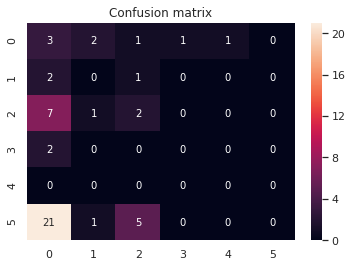

In [18]:
def test_classifier(test_sentences, test_annotations, classify_fn, signatures, log=False):
    label_counts = []
    lesk_counts = []    
    test_lesk_predictions = []
    for (sentence, label) in zip(test_sentences, test_annotations):
        lesk_label, _ = classify_fn(sentence, word, signatures, senses)
        test_lesk_predictions.append(lesk_label)
        
        label_counts.append(label)
        lesk_counts.append(lesk_label)
        if log:
            if label != lesk_label:
                print('Correct: ', label, '; Predicted', lesk_label)
                print(sentence)

    print(Counter(label_counts))
    print(Counter(lesk_counts))

    print('Accuracy:', accuracy_score(test_annotations, test_lesk_predictions))
    
    
    cm = confusion_matrix(test_annotations, test_lesk_predictions)
    sns.heatmap(cm, annot=True)
    plt.title('Confusion matrix')
    plt.show()
    
    return test_lesk_predictions

test_lesk_predictions = test_classifier(test_sentences, test_annotations, classify, signatures)

## Improve WSD

> **Extended word lists for senses. Took into account word count and counting IDF score. Made predictions based on TF-IDF weights.**

In [19]:
def collect_tc(text):
    """
    Tokenize TEXT with tokenize_uk, lemmatize TEXT with pymorphy2, and remove functional words.
    Return as Term Count
    """
    tokens = tokenize_uk.tokenize_words(text)
    bow = []
    for token in tokens:
        parse = morph.parse(token)[0]
        if parse.tag.POS not in {'NUMR', 'NPRO', 'PREP', 'CONJ', 'PRCL'} and \
           not 'PNCT' in parse.tag and \
           not token.isdigit() and \
           token not in stopwords_uk and \
           parse.normal_form not in stopwords_uk and \
           parse.normal_form != word:
            
            bow.append(parse.normal_form)
    return Counter(bow)

def tc_to_tf(tc):
    n = np.sum(list(tc.values()))
    tf = dict()
    for key in tc:
        tf[key] = tc[key] / n
    return tf

def idf(counters):
    all_words = set(counters[0].keys())
    for counter in counters[1:]:
        all_words = all_words.union(counter.keys())
    return {word: np.log(len(counters) / 
                         np.sum([word in doc for doc in counters])) for word in all_words}

def subsetter(c, sub):
    out = {}
    for x in sub:
        out[x] = c[x]
    return Counter(out)

def add_to_counter(counter, value):
    if value not in counter.keys():
        counter[value] = 1
    else:
        counter[value] += 1

In [20]:
signatures_tc = [(idx, collect_tc(sense)) for idx, sense in senses_with_examples]

print('Term Counts for Senses')
for signature in signatures_tc[:2]:
    print('===================== Sense', signature[0], '=====================')
    print(signature[1])
print('...')

Term Counts for Senses
===================== Sense 1 =====================
Counter({'диво': 11, 'світ': 4, 'люди': 3, 'небесний': 2, 'світило': 2, 'великий': 2, 'золотий': 2, 'довіку': 2, 'жити': 2, 'бачити': 2, 'шотландський': 2, 'воля': 2, 'світа': 2, 'рана': 2, 'нарід': 2, 'напрямок': 2, 'рух': 2, 'місце': 2, 'проти': 2, 'центральний': 1, 'сонячний': 1, 'система': 1, 'мати': 1, 'форма': 1, 'гігантський': 1, 'розжарений': 1, 'кулі': 1, 'випромінювати': 1, 'світло': 1, 'тепло': 1, 'термоядерний': 1, 'реакція': 1, 'відбуватися': 1, 'надра': 1, 'супроводжуватися': 1, 'виділення': 1, 'кількість': 1, 'нейтрино': 1, 'виглянути': 1, 'діброва': 1, 'висунути': 1, 'чоло': 1, 'пучко': 1, 'кучер': 1, 'навкруги': 1, 'зажуритися': 1, 'тарас': 1, 'григорович': 1, 'сторінка': 1, 'крихітний': 1, 'книжечка': 1, "з'явитися": 1, 'сумний': 1, 'рядок': 1, 'гріти': 1, 'чужина': 1, 'осліплювати': 1, 'яскравий': 1, 'сяйво': 1, 'люстра': 1, 'світити': 1, 'час': 1, 'вічно': 1, 'лихий': 1, 'минутися': 1, 'забут

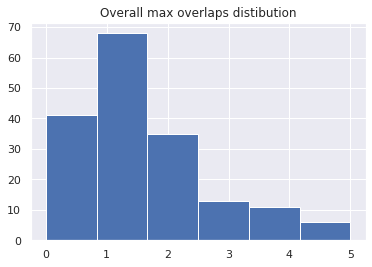

===================== Sentence 1 =====================
overlaps: {'вода', 'криниця', 'сонячний', 'день', 'мати'}
correct: 3 , lesk result: 1
===================== Sentence 3 =====================
overlaps: {'показати', 'світлий', 'сонячний', 'перти'}
correct: 6 , lesk result: 3
===================== Sentence 4 =====================
overlaps: {'перти', 'світло', 'мати', 'диво', 'система'}
correct: 6 , lesk result: 1
===================== Sentence 11 =====================
overlaps: {'мати', 'розжарений'}
correct: 6 , lesk result: 1
===================== Sentence 12 =====================
overlaps: {'процес', 'надра'}
correct: 6 , lesk result: 1
===================== Sentence 14 =====================
overlaps: {'центральний', 'великий'}
correct: 6 , lesk result: 1
===================== Sentence 15 =====================
overlaps: {'реакція', 'термоядерний'}
correct: 6 , lesk result: 1
===================== Sentence 21 =====================
overlaps: {'раз', 'час', 'сонячний'}
correct: 6 , l

In [21]:
lesk_num_overlaps = [len(overlap) for overlap in lesk_overlaps]
plt.hist(lesk_num_overlaps, bins=len(np.unique(lesk_num_overlaps)))
plt.title('Overall max overlaps distibution')
plt.show()

num_errors = 0
for i, (label, lesk_label) in enumerate(zip(test_annotations, test_lesk_predictions)):
    if label != lesk_label and lesk_num_overlaps[i] >= 2:
        print('===================== Sentence', i+1, '=====================')
        print('overlaps:', lesk_overlaps[i])
        print('correct:', label, ', lesk result:', lesk_label)
        num_errors += 1
print(num_errors)

In [22]:
print('Word:', word)
for sense in senses:
    print('===================== Sense', sense[0], '=====================')
    print(sense[1])

Word: сонце
===================== Sense 1 =====================
 Центральне небесне світило сонячної «системи, що має форму гігантської розжареної кулі, яка випромінює світло й тепло
===================== Sense 2 =====================
 Відбиття, відображення чим-небудь або у чомусь цього небесного світила
===================== Sense 3 =====================
 Світло й тепло, що випромінюються цим світилом
===================== Sense 4 =====================
 Про те (того), хто (що) є джерелом життя, втіхи, радості і т
===================== Sense 5 =====================
 Те, що освітлює шлях, той, хто веде за собою  (у житті, боротьбі і т
===================== Sense 6 =====================
 Центральна планета інших планетних систем
===================== Sense 7 =====================
 Гімнастична вправа на турніку


In [23]:
for i in range(3):
    for value in ['захід', 'схід']:
        add_to_counter(signatures_tc[0][1], value)
        
    for value in ['відбивати', 'щуритись']:
        add_to_counter(signatures_tc[1][1], value)
        
    for value in ['обличчя', 'світло', 'тепло', 'світлий', 'промені', 'освітити']:
        add_to_counter(signatures_tc[2][1], value)
        
    for value in ['джерело', 'радість', 'людина', 'життя']:
        add_to_counter(signatures_tc[3][1], value)

    for value in ['шлях', 'життя', 'вести', 'показувати']:
        add_to_counter(signatures_tc[4][1], value)    

    for value in ['астроном', 'реакція', 'процес', 'планета', 'система', 'енергія',
                  'наука', 'характеристика', 'космос', 'зірка', 'комета',
                  'модель', 'модельний', 'спектр', 'сфера', 'температура', 'шар']:
        add_to_counter(signatures_tc[5][1], value)
        
    for value in ['гімнастика', 'тіло', 'спорт']:
        add_to_counter(signatures_tc[6][1], value)

In [24]:
signatures_tf = [(idx, tc_to_tf(tc)) for idx, tc in signatures_tc]

print('Term Frequencies for Senses')
for signature in signatures_tf[:1]:
    print('===================== Sense', signature[0], '=====================')
    print(signature[1])
print('...')

Term Frequencies for Senses
===================== Sense 1 =====================
{'центральний': 0.005076142131979695, 'небесний': 0.01015228426395939, 'світило': 0.01015228426395939, 'сонячний': 0.005076142131979695, 'система': 0.005076142131979695, 'мати': 0.005076142131979695, 'форма': 0.005076142131979695, 'гігантський': 0.005076142131979695, 'розжарений': 0.005076142131979695, 'кулі': 0.005076142131979695, 'випромінювати': 0.005076142131979695, 'світло': 0.005076142131979695, 'тепло': 0.005076142131979695, 'термоядерний': 0.005076142131979695, 'реакція': 0.005076142131979695, 'відбуватися': 0.005076142131979695, 'надра': 0.005076142131979695, 'супроводжуватися': 0.005076142131979695, 'виділення': 0.005076142131979695, 'великий': 0.01015228426395939, 'кількість': 0.005076142131979695, 'нейтрино': 0.005076142131979695, 'виглянути': 0.005076142131979695, 'діброва': 0.005076142131979695, 'висунути': 0.005076142131979695, 'золотий': 0.01015228426395939, 'чоло': 0.005076142131979695, 'пу

In [25]:
signatures_idf = idf([tc[1] for tc in signatures_tc])
print('Inverse Document (Senses as Documents) Frequencies:')
print(dict(subsetter(signatures_idf, {'світило', 'бачити', 'відбиття', 'великий',
                                      'небесний', 'життя', 'планета'})), '...')

Inverse Document (Senses as Documents) Frequencies:
{'світило': 0.8472978603872037, 'відбиття': 1.252762968495368, 'бачити': 1.252762968495368, 'великий': 1.9459101490553132, 'небесний': 1.252762968495368, 'планета': 1.9459101490553132, 'життя': 0.8472978603872037} ...


In [26]:
signatures_tfidf = [(idx, {word: tf[word] * signatures_idf[word]
                           for word in tf})
                                    for idx, tf in signatures_tc]

print('TF-IDF for Senses')
for signature in signatures_tfidf[:1]:
    print('===================== Sense', signature[0], '=====================')
    print(signature[1])
print('...')

TF-IDF for Senses
===================== Sense 1 =====================
{'центральний': 1.252762968495368, 'небесний': 2.505525936990736, 'світило': 1.6945957207744073, 'сонячний': 1.252762968495368, 'система': 1.252762968495368, 'мати': 1.9459101490553132, 'форма': 1.9459101490553132, 'гігантський': 1.9459101490553132, 'розжарений': 1.252762968495368, 'кулі': 1.9459101490553132, 'випромінювати': 1.9459101490553132, 'світло': 1.252762968495368, 'тепло': 0.8472978603872037, 'термоядерний': 1.9459101490553132, 'реакція': 1.252762968495368, 'відбуватися': 1.9459101490553132, 'надра': 1.9459101490553132, 'супроводжуватися': 1.9459101490553132, 'виділення': 1.9459101490553132, 'великий': 3.8918202981106265, 'кількість': 1.9459101490553132, 'нейтрино': 1.9459101490553132, 'виглянути': 1.9459101490553132, 'діброва': 1.9459101490553132, 'висунути': 1.9459101490553132, 'золотий': 3.8918202981106265, 'чоло': 1.9459101490553132, 'пучко': 1.9459101490553132, 'кучер': 1.9459101490553132, 'навкруги': 

In [27]:
def classify_advanced(sentence, word, senses_tfidf, senses_text, log=False):
    """
    Find the sense that has the biggest overlap with the word context.
    Use sense 1 as default.
    """
    tc = collect_tc(sentence)
    best_sense = 1
    max_score = 0
    for sense_id, signature in senses_tfidf:
        weights = [signature[word] for word in tc if word in signature]
        score = np.prod(weights)
        if score > max_score:
            best_sense = sense_id
            max_score = score
            best_weights = weights
    if log:
        print(" ".join(sentence))
        print("Best sense:", best_sense, "--", senses_text[best_sense-1][1])
    return best_sense, best_weights

Counter({6: 27, 3: 10, 1: 8, 2: 3, 4: 2})
Counter({6: 19, 1: 16, 3: 8, 2: 3, 4: 2, 7: 1, 5: 1})
Accuracy: 0.58


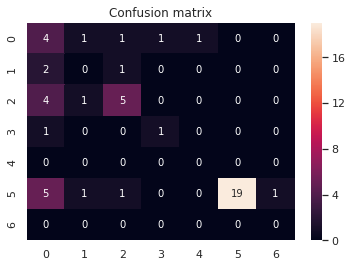

In [28]:
test_lesk_predictions = test_classifier(test_sentences, test_annotations,
                                        classify_advanced, signatures_tfidf)

> **So there is an improvement (Accuracy: 0.1 -> 0.58, and Confusion Matrix looks more diagonal). Note that the word is hard to disambiguate in some cases even for a person since there is a thin line between several senses**